In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import dill

import sys
sys.path.append("../../")

import biked_commons
from biked_commons.prediction import aero_predictor, loaders
from biked_commons.resource_utils import models_and_scalers_path
from biked_commons.prediction.prediction_utils import TorchStandardScaler, DNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
X_tv, Y_tv = loaders.load_aero()
X_tv_tens = torch.tensor(X_tv.values, dtype=torch.float32, device=device)
Y_tv_tens = torch.tensor(Y_tv.values, dtype=torch.float32, device=device)

In [3]:
X_tv_tens = aero_predictor.calculate_features(X_tv_tens, device=device)

/home/mileva/Documents/Lyle/biked-commons/src/biked_commons/prediction/../../biked_commons/prediction/aero_predictor.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  upper_leg_width = torch.tensor((torso_width/2 - 0.16)/2 + 0.14, device=device)


In [4]:
scaler = TorchStandardScaler().to(device)
scaler.fit(X_tv_tens)


scaler_path = models_and_scalers_path("aero_scaler.pt")
torch.save(scaler, scaler_path)

X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)

/tmp/ipykernel_3041986/4180995027.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tv_tens = torch.tensor(scaler.transform(X_tv_tens), dtype=torch.float32, device=device)


In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tv_tens, Y_tv_tens, test_size=0.2, random_state=42)

In [6]:
# Define the model, loss function, and optimizer
input_dim = X_train.shape[1]
output_dim = 1
model = DNN(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
batch_size = 32
best_val_loss = float('inf')
best_model = None

bar = trange(num_epochs, desc="Training")
for epoch in bar:
    model.train()
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        batch_x, batch_y = X_train[indices], Y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model = model

    bar.set_postfix({
        'loss': f'{loss.item():.4f}',
        'val_loss': f'{val_loss.item():.4f}',
        'best_val': f'{best_val_loss:.4f}'
    })



Training: 100%|██████████| 500/500 [00:30<00:00, 16.36it/s, loss=0.6733, val_loss=0.2898, best_val=0.2510] 


In [7]:
save_path = models_and_scalers_path("aero_model.pt")
torch.save(best_model, save_path)

In [8]:
model = torch.load(save_path)

/tmp/ipykernel_3041986/1837872702.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(save_path)


Text(0.5, 1.0, 'R2 Score: 0.9588')

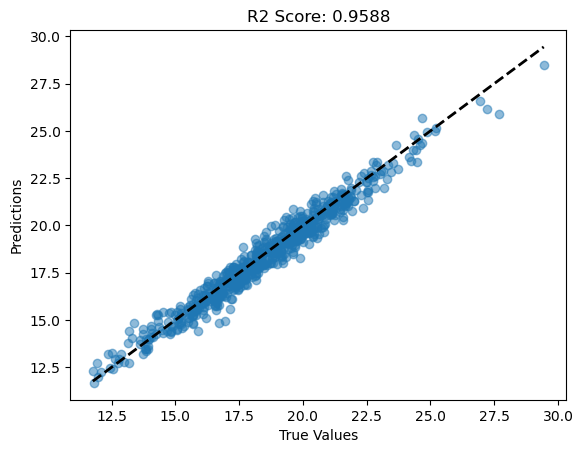

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Calculate metrics

Y_val_npy = Y_val.cpu().detach().numpy()
val_outputs = best_model(X_val).cpu().detach().numpy()
r2 = r2_score(Y_val_npy, val_outputs)

plt.scatter(Y_val_npy, val_outputs, alpha=0.5)
plt.plot([Y_val_npy.min(), Y_val_npy.max()], [Y_val_npy.min(), Y_val_npy.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'R2 Score: {r2:.4f}')

In [10]:
import evaluators

evaluators.evaluate_aero(model, aero_predictor.AeroPreprocessor(device), device=device)

/home/mileva/Documents/Lyle/biked-commons/src/biked_commons/prediction/../../biked_commons/prediction/aero_predictor.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  se

0.957561194896698